In [135]:
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import numpy as np
from numpy import random, pi, array
import swarms
import pread as pds
from random import randint, seed, uniform

In [136]:
Mmoon = 7.35e22
Mjup = 1.898e27
Rjup = 7.1492e7
AU = 1.496e11
Rearth = 6.3781e6
Mearth = 5.972e24
pc = 3.086e16
Msun = 1.989e30
Lsun = 3.828e26
Year = 3.154e7 # seconds
KM = 1e3

In [137]:
def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def star_samplerM(mean=2., std=1.):
    '''
    Mstar = None
    Lstar = None
    Tstar = None
    dpl = None
    
    sample = int(random.normal(loc=mean, scale=std))
    sampled_type = 'M' + str(sample)
    for i in range(len(GPI['S_Type'])):
        if sampled_type in GPI['S_Type'][i]:
            Tstar = GPI['Teff'][i]
            Lstar = GPI['Lum'][i]*Lsun
            Mstar = GPI['Mass'][i]*Msun
            dpl = GPI['Distance_distance'][i]*pc
            break
    '''
    # Table 1 (KALTENEGGER & TRAUB) https://arxiv.org/ftp/arxiv/papers/0903/0903.3371.pdf
    ML = [7.2/100., 3.5/100., 2.3/100., 1.5/100., 0.55/100., 0.22/100., 0.09/100., 0.05/100., 0.03/100., 0.015/100.]
    MM = [0.60, 0.49, 0.44, 0.36, 0.20, 0.14, 0.10, 0.09, 0.08, 0.075]
    MT = [3800, 3600, 3400, 3250, 3100, 2800, 2600, 2500, 2400, 2300]
    sample = -1
    while sample < 0 or sample > 9:
        sample = int(random.normal(loc=mean, scale=std))
    
    return swarms.Star(M=MM[sample]*Msun, L=ML[sample]*Lsun, T=MT[sample], d=0) # M star    

def distance_sampler(mean, std):
    s = 0
    while s <= 0:
        s = random.normal(loc=mean, scale=std)
    return s

def draw_planet(star, age, IWA=0.2, OWA=1.2):
    Mmin = 21 # Mearth (Nep)
    Mmax = 5*318 # Mearth (Jup)
    # Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
    totoccurrence = 1.
    Npts = 1000
    alpha = -0.86
    Q = 0.5 # planet albedo
    ms = np.linspace(Mmin, Mmax, Npts)
    pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
    cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
    randv = np.random.uniform()
    idx = np.searchsorted(cumpdf, randv)
    if idx == len(cumpdf):
        return None # didn't draw a planet
    else:
        # draw semimajor axis
        amin = star.d/pc*IWA# AU
        amax = star.d/pc*OWA # AU
        a = loguniform(amin, amax)
        return swarms.Planet(star, M=ms[idx]*Mearth , R=None, a=a*AU, Q=Q, Z='002', age=age)

def inverse_cdf(y):
    A = -0.785
    B = 0.603
    return 10**((y - A)/B)  

def age_sampler():
    y = uniform(0, 1)
    return inverse_cdf(y)*1e6 * Year

def computeQd(D, rho, fQ):
    """Compute the planetesimal strength of an object."""
    return 0.1*rho*(D/KM)**1.26/fQ

In [138]:
def aoptChar(Mstar, Mtot, tage):
    star = swarms.Star(Lsun, Mstar, 6000, d=0)
    planet = draw_planet(star, tage)
    if planet is None:
        return aoptChar(Mstar, Mtot, tage) # do it again
    Dc = loguniform(1e4, 1e6) # m
    rho = 1000 # kg/m^3
    eta = 0.5 # eta
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    f_vrel = 4./pi
    
    part1 = (Mstar/Msun)**0.33 * f_vrel**0.55
    part2 = (planet.M/Mearth)**0.06 * computeQd(Dc, rho, fQ)**0.15 * eta
    part3 = tage / (30e6*Year) * Mtot/Mearth / rho / (Dc/KM)
    return 50. * part1 / part2 * part3**0.24 * AU

In [139]:
def aoptClean(star, Mtot, age, planet, Dt, Nstr, fQ, Dc, rho, eta, charFactor=1., f_vrel=4./pi):
    part1 = (star.M/Msun)**0.33 * f_vrel**0.55
    part2 = (planet.M/Mearth)**0.06 * computeQd(Dc, rho, fQ)**0.15 * eta
    part3 = age / (30e6*Year) * Mtot/Mearth / rho / (Dc/KM)
    return charFactor * 50. * part1 / part2 * part3**0.24 * AU

In [140]:
def aopt(Mtot):
    star = star_samplerM()
    star.d = 10*pc # dummy value
    age = age_sampler()
    planet = draw_planet(star, age)
    if planet is None:
        return aopt(Mtot) # do it again
    Dc = loguniform(1e4, 1e6) # m
    rho = 1000 # kg/m^3
    eta = 0.5 # eta
    Q = loguniform(0.05, 0.25) # Q_bd = [0, 0.8]
    g = loguniform(0.2, 0.8) # 0.32 https://arxiv.org/pdf/1709.00417.pdf
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    swarm = swarms.CollSwarm(star, planet, Mtot, Dt, Dmax, Q=Q, eta=eta, Nstr=Nstr, 
                            rho=rho, fQ=fQ, correction=True, Dmin_min=1.65)
    return swarm.aopt(t=age)

## Distribution of aopt given characteristic values

In [141]:
aopt = []
for i in range(500):
    aopt.append(aoptChar(Msun, Mearth, 30e6*Year)/AU)

c:\users\loloynage\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


(array([124., 105.,  64.,  63.,  35.,  27.,  28.,  32.,  11.,  11.]),
 array([0.44793415, 0.82117278, 1.19441141, 1.56765005, 1.94088868,
        2.31412731, 2.68736594, 3.06060457, 3.43384321, 3.80708184,
        4.18032047]),
 <a list of 10 Patch objects>)

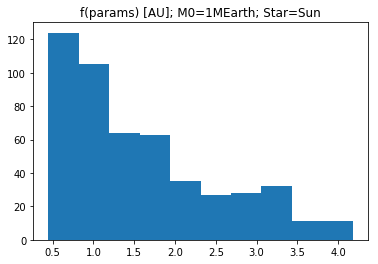

In [142]:
fig, ax = plt.subplots()
ax.set_title("f(params) [AU]; M0=1MEarth; Star=Sun")
ax.hist(aopt)

## Sampling Stars

In [143]:
def sample(M0, lamb):
    starChar = swarms.Star(Lsun, Msun, 6000, d=0)
    ageChar = 30e6*Year
    star = swarms.Star(0.072*Lsun, 0.60*Msun, 3800, d=0) # M0
    # star = swarms.Star(0.16*Lsun, 0.69*Msun, 4410, d=0) # K5
    #star.d = distance_sampler(mean=dopt-(65*pc), std=(dopt-(65*pc))/6.)
    age = age_sampler()
    
    planet = draw_planet(star, age=age)
    if planet is None:
        return sample(M0, lamb) # do it again
    
    Dc = loguniform(1e4, 1e6) # m
    rho = 1000 # kg/m^3
    eta = 0.5 # eta
    Q = loguniform(0.05, 0.25) # Q_bd = [0, 0.8]
    g = loguniform(0.2, 0.8) # 0.32 https://arxiv.org/pdf/1709.00417.pdf
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    
    charAopt = aoptClean(starChar, Mearth, ageChar, planet, Dt, Nstr, fQ, Dc, rho, eta)
    a_opt = aoptClean(star, M0, age, planet, Dt, Nstr, fQ, Dc, rho, eta, charFactor=charAopt/AU)
    #print("charAopt = "+str(charAopt/AU)+"\t aopt = "+str(a_opt/AU))
    star.d = a_opt/(AU*0.7)*pc
    
    swarm = swarms.CollSwarm(star, planet, M0, Dt, Dmax, Q=Q, eta=eta, Nstr=Nstr, 
                            rho=rho, fQ=fQ, correction=True, Dmin_min=lamb, age=age)
    
    CRscatSwarm = swarm.CRscat(g)
    CRscatPlanet = planet.CRscat(g)
    CRthermalPlanet = planet.CRthermal(lamb)
    if np.isnan(CRthermalPlanet):
        CRthermalPlanet = 0
    return CRscatSwarm, CRscatPlanet+CRthermalPlanet, planet.a/AU, star.d/pc, planet.M, star.Imag(), a_opt/(AU*0.7)

In [144]:
%%time
seed(0)
M0 = 1*Mearth
lamb = 1.65e-6
Nsamples = 300
CRscatSwarm1, CRPlanet1, a, d, Mplt, Imag, d_opt = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm1[i], CRPlanet1[i], a[i], d[i], Mplt[i], Imag[i], d_opt[i] = sample(M0, lamb)

c:\users\loloynage\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Wall time: 37.3 s


(array([163.,  57.,  25.,  17.,  12.,  15.,   6.,   1.,   2.,   2.]),
 array([ 0.28816875,  4.30047655,  8.31278434, 12.32509213, 16.33739992,
        20.34970771, 24.3620155 , 28.3743233 , 32.38663109, 36.39893888,
        40.41124667]),
 <a list of 10 Patch objects>)

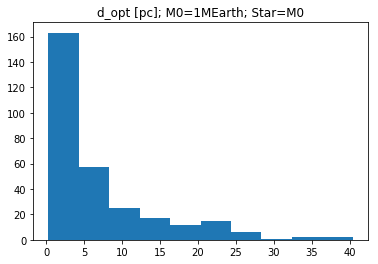

In [150]:
fig, ax = plt.subplots()
ax.set_title("d_opt [pc]; M0=1MEarth; Star=M0")
ax.hist(d_opt)

(array([163.,  57.,  25.,  17.,  12.,  15.,   6.,   1.,   2.,   2.]),
 array([ 0.20171813,  3.01033358,  5.81894904,  8.62756449, 11.43617994,
        14.2447954 , 17.05341085, 19.86202631, 22.67064176, 25.47925722,
        28.28787267]),
 <a list of 10 Patch objects>)

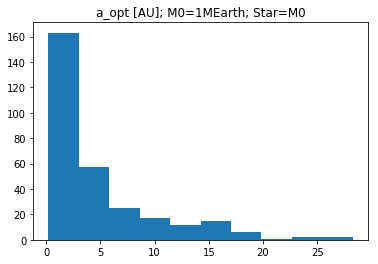

In [149]:
fig, ax = plt.subplots()
ax.set_title("a_opt [AU]; M0=1MEarth; Star=M0")
ax.hist(d_opt*0.7)

(array([14., 21., 29., 43., 37., 39., 43., 30., 34., 10.]),
 array([-0.72314458,  0.3502831 ,  1.42371078,  2.49713846,  3.57056614,
         4.64399382,  5.7174215 ,  6.79084918,  7.86427686,  8.93770454,
        10.01113222]),
 <a list of 10 Patch objects>)

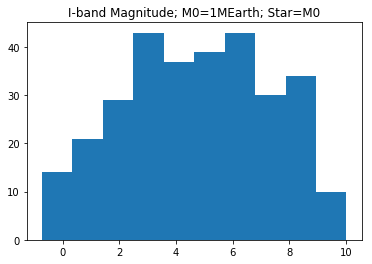

In [148]:
fig, ax = plt.subplots()
ax.set_title("I-band Magnitude; M0=1MEarth; Star=M0")
ax.hist(Imag)